In [1]:
import numpy as np
import scipy.linalg as linalg
import scipy.signal as signal
import random
import cvxpy as cp
from helper import awgn, draw, draw_3d, hermitian, toep, complexAGWN
import sdpt3glue.solve as slv
epsilon = 1e-11

(10, 500)


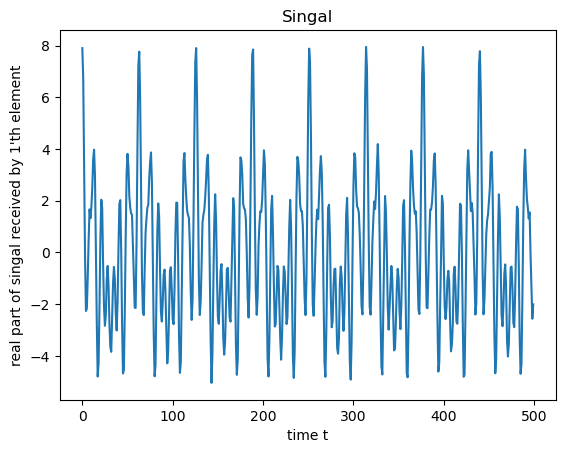

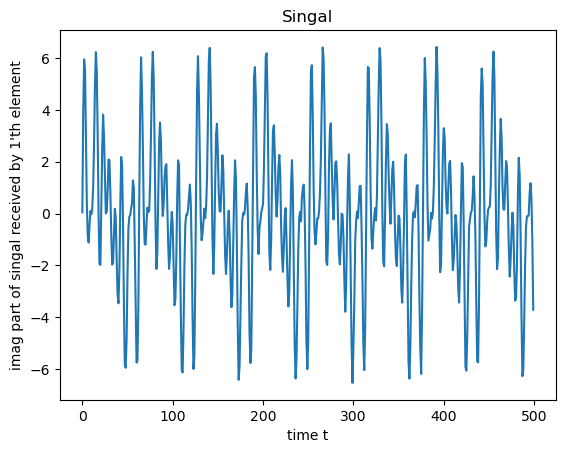

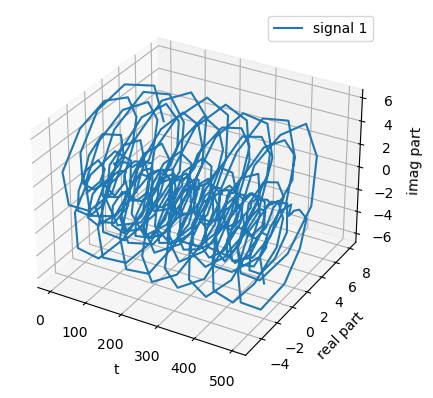

In [2]:
# signal model
SNR = 1
N = 500 # number of samples
M = 10 # number of arr elem
f = [ 0.1, 0.5, 0.6, 0.9 ]
a = lambda f : np.array([ np.exp(-1j* i * 2 * np.pi * f ) for i in range(M) ], dtype=complex).reshape((M,1))
A = np.hstack([ a(ff) for ff in f ])
s = lambda f : 2 * np.exp( 1j * f * np.array([ i for i in range(N) ]).reshape((N,1)) )
S = np.hstack([ s(ff) for ff in f ]).T
X = A @ S
X += complexAGWN(0.2, X.shape)
print(X.shape)
draw(list(range(N)), np.real(X[0,:]), "time t", "real part of singal received by {}'th element".format(0+1), "Singal")
draw(list(range(N)), np.imag(X[0,:]), "time t", "imag part of singal received by {}'th element".format(0+1), "Singal")
draw_3d(list(range(N)), np.real(X[0,:]), np.imag(X[0,:]), "t", "real part", "imag part")

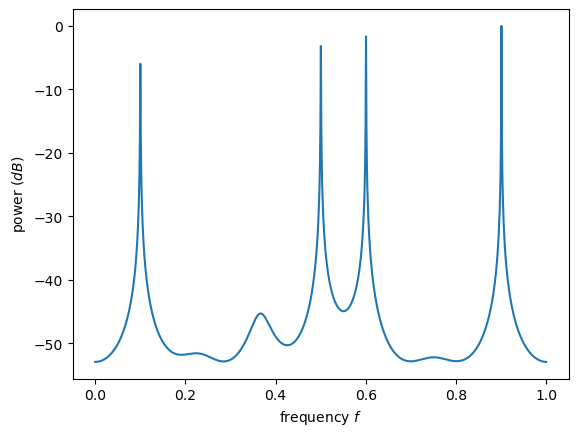

In [3]:
numSampling = 1000
def MUSIC(X, numFreq):
  Rxx = X @ hermitian(X)
  eigVal, eigVec = np.linalg.eigh(Rxx)
  NN = eigVec[:, 0:M-numFreq-1]
  Pmusic = np.array([ 0.0 for _ in range(numSampling) ])
  for ii in range(numSampling):
    fx = (1-0)/numSampling * ii
    SS = np.array([np.exp( -1j * 2 * np.pi * k * fx ) for k in range(M)])
    P = hermitian(SS) @ (NN @ hermitian(NN)) @ SS
    Pmusic[ii] = 1 / np.abs(P)
  pMax = np.max(Pmusic)
  Pmusic = np.real(10*np.log10(Pmusic/pMax))
  # Pmusic = np.real(Pmusic/pMax)
  return Pmusic

xx = np.linspace(0,1,numSampling)
y = MUSIC(X,len(f))
draw(xx,y,"frequency $f$","power $(dB)$","")

In [4]:
peaks, props = signal.find_peaks(y, prominence=len(f))
print(xx[peaks])

[0.1001001  0.36736737 0.5005005  0.6006006  0.9009009 ]


In [5]:
def ANM(y, tau):
  t = cp.Variable((1,1), complex=True)
  x = cp.Variable((M,1), complex=True)
  u = cp.Variable((M,1), complex=True)
  constraints = [ cp.bmat([
    [toep(u), x],
    [    x.H, t ]
  ]) >> 0 ]
  prob = cp.Problem(cp.Minimize( cp.real(0.5*cp.norm2(x-y)**2 + tau/2 * (t+u[0])) ), constraints)
  prob.solve()

  print("x: ", x.value)
  print("u: ", u.value)
  print("t: ", t.value)
  
ANM(X[:,0].reshape(M,1), len(f))
    


x:  [[ 6.07264822+0.01000026j]
 [-0.15428113+1.16319652j]
 [ 3.29403079-1.62860487j]
 [-2.04538118+1.69107809j]
 [-2.26516688-0.98550177j]
 [-3.19928738-0.13106759j]
 [-2.15030623+1.2222776j ]
 [-2.19714508-1.81106381j]
 [ 3.43912861+1.624954j  ]
 [-0.18292809-1.08962431j]]
u:  [[ 6.24742736+0.j        ]
 [-0.13177407+0.84966156j]
 [ 2.66456914-1.24755968j]
 [-1.86132204+1.0223845j ]
 [-2.68493516+0.0587158j ]
 [-3.14985195-0.95302783j]
 [-1.81762525+2.12588482j]
 [-2.16849507-2.30039452j]
 [ 3.74414347+1.7822708j ]
 [ 0.15324377-1.28161662j]]
t:  [[6.24741814+0.j]]


In [6]:
def ANM_MMV(X):
  u = cp.Variable((M,1), complex=True)
  W = cp.Variable((N,N), complex=True)
  constraints = [ cp.bmat([
    [ toep(u), X ],
    [hermitian(X), W]
  ]) >> 0]
  prob = cp.Problem(cp.Minimize( cp.real( 0.5 / M * cp.trace(toep(u)) + 0.5 * cp.trace(W) ) ), constraints)
  prob.solve()
  return u.value, W.value

u, W = ANM_MMV(X)

In [7]:
print(u.shape,W.shape)

(10, 1) (500, 500)
